# Regular Expression Dataset Generation

## Utilities
### Definitions

In [1]:
from dataset import Dataset

import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import keras
from keras import layers
from keras.preprocessing import sequence

from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.callbacks import History 

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

/Users/ischeinfeld/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Generate Dataset

### Generate, Balance, and Split

In [9]:
# Generate
alphabet = "abc"
regex_chars = "|*()1"
regex_max_len = 8
string_max_len = 6

dataset = Dataset(regex_max_len, string_max_len, alphabet, regex_chars)

print("Dataset Size Upper Bound: {}".format(dataset.bound_size()))

Dataset Size Upper Bound: 20957139373


In [ ]:
print("Generating data") # 90 mil takes 100 count, 0.01 makes 10 count
Xr, Xs, y = map(np.array, zip(*dataset.gen(random_frac=0.001)))

print("Shuffling data")
Xr, Xs, y = shuffle(Xr, Xs, y, random_state=42)
print("Initial data size: {}".format(Xr.shape))

# Balance
pos = (y == 1)
neg = (y == 0)
class_size = min(pos.sum(), len(pos) - pos.sum())
Xr_pos, Xs_pos, y_pos = Xr[pos][:class_size], Xs[pos][:class_size], y[pos][:class_size]
Xr_neg, Xs_neg, y_neg = Xr[neg][:class_size], Xs[neg][:class_size], y[neg][:class_size]

Xr = np.concatenate((Xr_pos, Xr_neg))
Xs = np.concatenate((Xs_pos, Xs_neg))
y = np.concatenate((y_pos, y_neg))

Xr, Xs, y = shuffle(Xr, Xs, y, random_state=42)

print("Balanced data size: {}".format(Xr.shape))

Generating data


### Prepare

In [24]:
# Split
Xr_train, Xr_test, Xs_train, Xs_test, y_train, y_test = train_test_split(Xr, Xs, y, test_size=0.6, random_state=42)

print("Train/Test split data size: {}/{}".format(Xr_train.shape, Xr_test.shape))

# Padding #TODO is this necessary?
Xr_train = sequence.pad_sequences(Xr_train, maxlen=regex_max_len)
Xs_train = sequence.pad_sequences(Xs_train, maxlen=string_max_len)

Xr_test = sequence.pad_sequences(Xr_test, maxlen=regex_max_len)
Xs_test = sequence.pad_sequences(Xs_test, maxlen=string_max_len)

regex_embedding_input_dim = len(alphabet + regex_chars) + 1
string_embedding_input_dim = len(alphabet) + 1

## LSTM

In [34]:
# build the model
regex_input = Input(shape=(regex_max_len,), name='regex_input')
regex_embedding = Embedding(regex_embedding_input_dim, 6, input_length=regex_max_len, name='regex_embedding')(regex_input)
regex_vector = LSTM(128, name='regex_lstm', return_sequences=False)(regex_embedding)

string_input = Input(shape=(string_max_len,), name='string_input')
string_embedding = Embedding(string_embedding_input_dim, 6, input_length=string_max_len, name='string_embedding')(string_input)
string_vector = LSTM(128, name='string_lstm', return_sequences=False)(string_embedding)

x = layers.concatenate([regex_vector, string_vector], name='concatenate')
x = layers.Dense(16, activation='relu')(x)
predictions = layers.Dense(1, activation='sigmoid', name='predictions')(x)

model = Model(inputs=[regex_input, string_input], outputs=predictions)
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

print(model.summary())

history = History()

h = model.fit([Xr_train, Xs_train],
          y_train,
          validation_data=([Xr_test, Xs_test], y_test),
              epochs=100,
          batch_size=64,
          callbacks=[history])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
regex_input (InputLayer)        (None, 5)            0                                            
__________________________________________________________________________________________________
regex_embedding (Embedding)     (None, 5, 6)         60          regex_input[0][0]                
__________________________________________________________________________________________________
regex_lstm (LSTM)               (None, 128)          69120       regex_embedding[0][0]            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 256)          0           regex_lstm[0][0]                 
                                                                 regex_lstm[0][0]                 
__________

KeyboardInterrupt: 

In [22]:
# Final evaluation of the model
scores = model.evaluate([Xr_test, Xs_test], y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

predictions = model.predict([Xr_test, Xs_test])


Accuracy: 88.07%


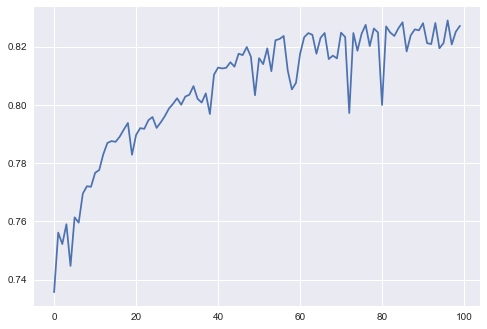

In [33]:
sns.set_style("darkgrid")
plt.plot(h.history['val_acc'])
plt.show()